可用变量： ['time', 'time_bnds', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'pre', 'pre_bnds', 'land_fraction', 'xch4', 'xch4_nobs', 'xch4_stderr', 'xch4_stddev', 'column_averaging_kernel', 'vmr_profile_ch4_apriori']
xch4维度： (210, 36, 72)


C:\Users\Morchaim&Hwachi\AppData\Local\Temp\ipykernel_20908\3773481447.py:43: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  xch4 = ds.variables[methane_var_name][:].astype(np.float64)  # 强制转为浮点型


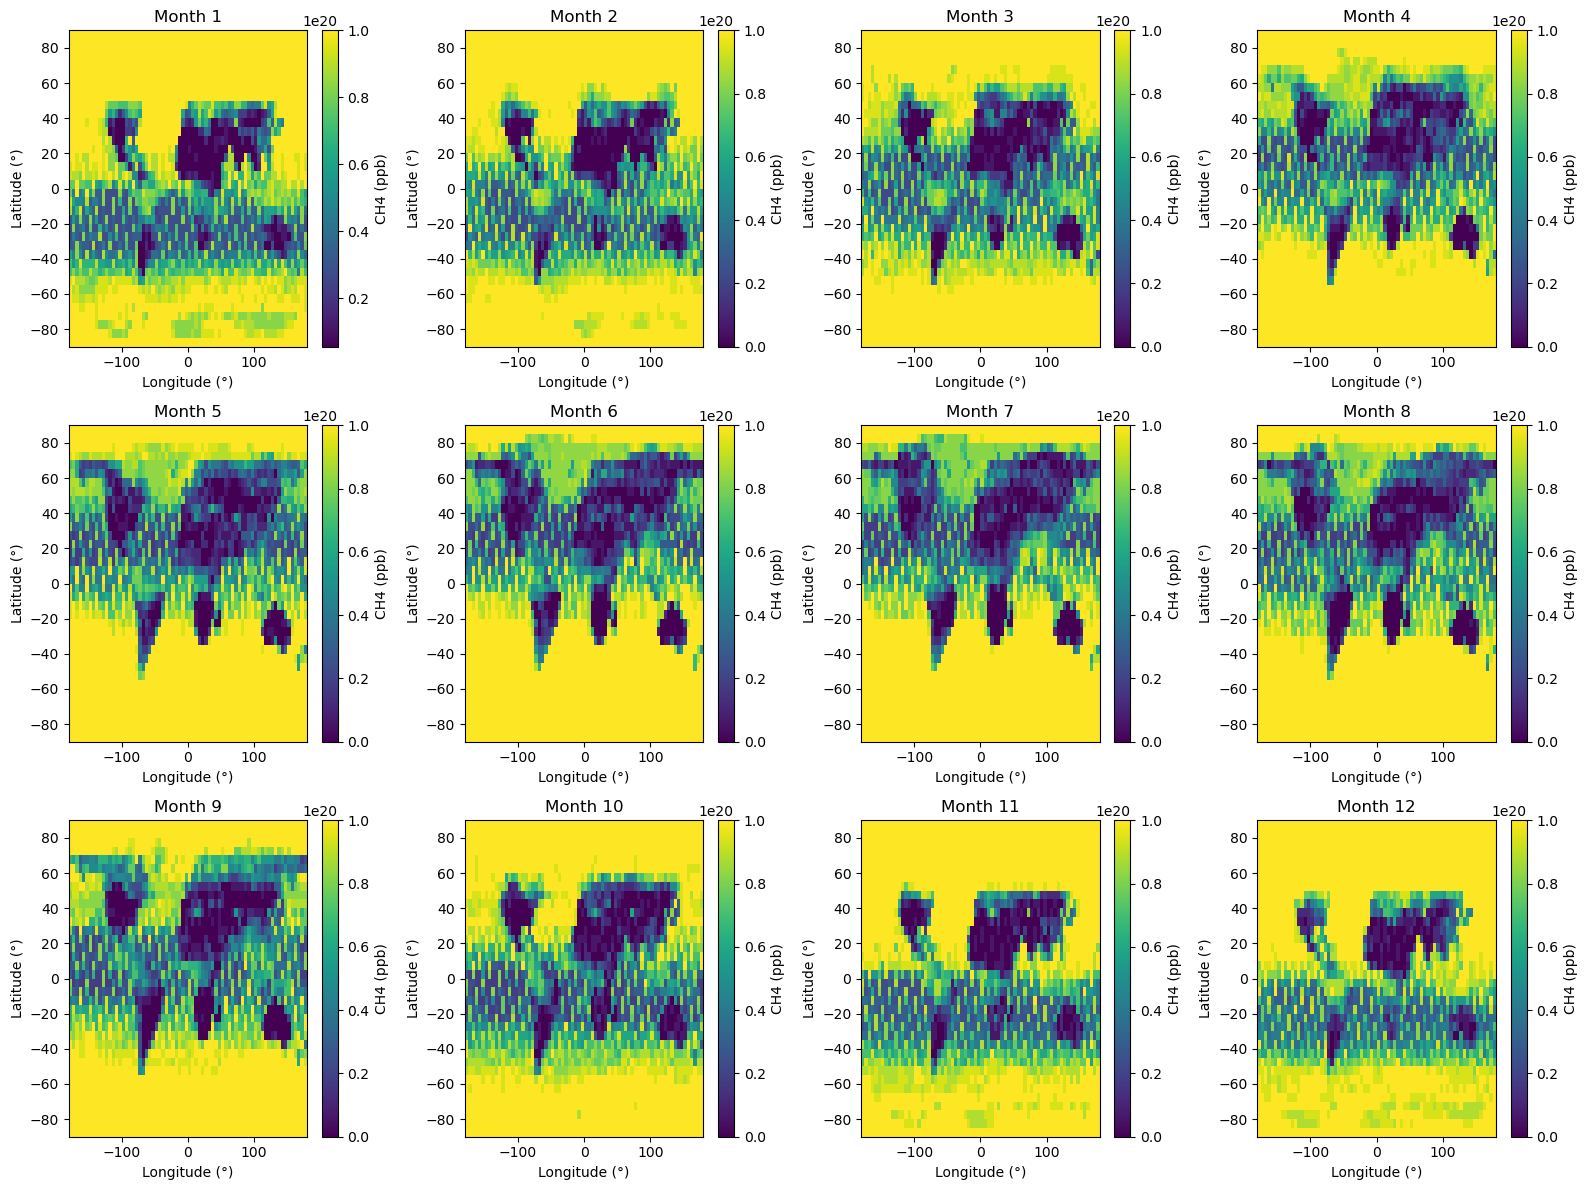

In [1]:
#任务1
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from netCDF4 import num2date
import os

nc_path = r'C:\Users\Morchaim&Hwachi\200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc'  
if not os.path.exists(nc_path):
    print(f"错误：文件不存在！路径：{nc_path}")
    exit()
try:
    ds = nc.Dataset(nc_path)
except Exception as e:
    print(f"打开文件失败：{e}")
    exit()

print("可用变量：", list(ds.variables.keys()))

# 处理时间变量（强制转为pandas datetime）
time = ds.variables['time'][:]
time_units = ds.variables['time'].units
time_calendar = ds.variables['time'].calendar if hasattr(ds.variables['time'], 'calendar') else 'gregorian'
# 先转为datetime对象列表，再强制转为pandas datetime
dates = num2date(time, units=time_units, calendar=time_calendar)
df_time = pd.DataFrame({'date': dates})
df_time['date'] = pd.to_datetime(df_time['date'].astype(str))  # 强制转换为pandas datetime
months = df_time['date'].dt.month  # 提取月份

# 处理甲烷变量（确认维度和类型）
methane_var_name = 'xch4'  
xch4 = ds.variables[methane_var_name][:].astype(np.float64)  # 强制转为浮点型
print("xch4维度：", xch4.shape)  # 确认维度为 [time, lat, lon]


# 任务1.1： 每月甲烷气候学 （12面板绘图）

lon = ds.variables['lon'][:]
lat = ds.variables['lat'][:]

climatology = []
for month in range(1, 13):
    month_mask = (months == month)
    if not np.any(month_mask):
        print(f"警告：无第{month}月数据，将用0填充")
        climatology.append(np.zeros((len(lat), len(lon))))
        continue
    monthly_data = xch4[month_mask, :, :]
    monthly_mean = np.nanmean(monthly_data, axis=0)  # 沿时间轴平均
    climatology.append(monthly_mean)
climatology = np.array(climatology)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()
for i in range(12):
    im = axes[i].pcolormesh(lon, lat, climatology[i], cmap='viridis')
    axes[i].set_title(f'Month {i+1}')
    axes[i].set_xlabel('Longitude (°)')
    axes[i].set_ylabel('Latitude (°)')
    fig.colorbar(im, ax=axes[i], label='CH4 (ppb)')
plt.tight_layout()
plt.savefig('monthly_climatology.png')
plt.show()

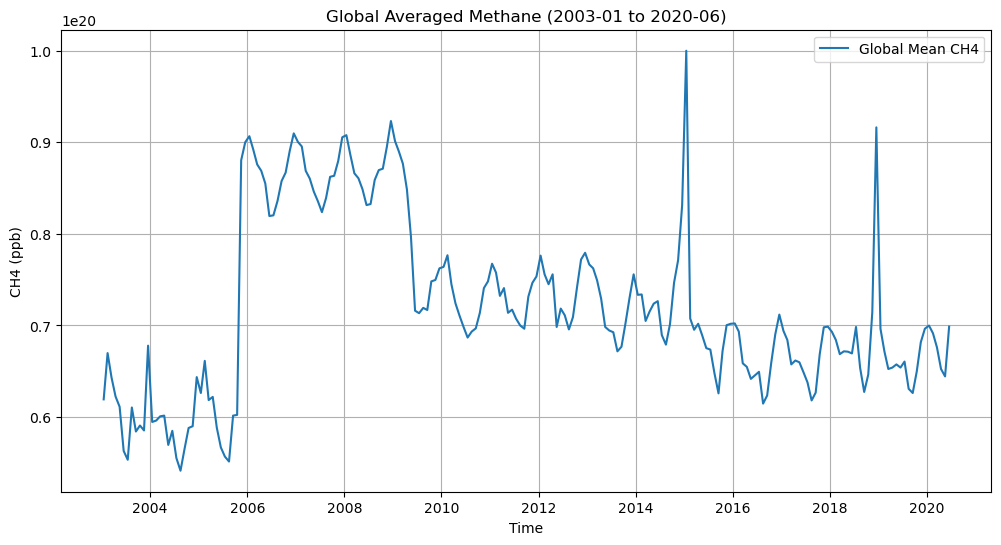

In [2]:
# 任务1.2： 全球平均甲烷时间序列
global_means = []
for t in range(len(df_time)):
# xch4维度是 [time, lat, lon]，对lat平均用axis=0，lon平均用axis=1
    lat_mean = np.nanmean(xch4[t, :, :], axis=0)  # 纬度方向（第1轴）平均
    global_mean = np.nanmean(lat_mean)           # 经度方向（第0轴）平均
    global_means.append(global_mean)

plt.figure(figsize=(12, 6))
plt.plot(df_time['date'], global_means, label='Global Mean CH4')
plt.xlabel('Time')
plt.ylabel('CH4 (ppb)')
plt.title('Global Averaged Methane (2003-01 to 2020-06)')
plt.grid(True)
plt.legend()
plt.savefig('global_mean_time_series.png')
plt.show()

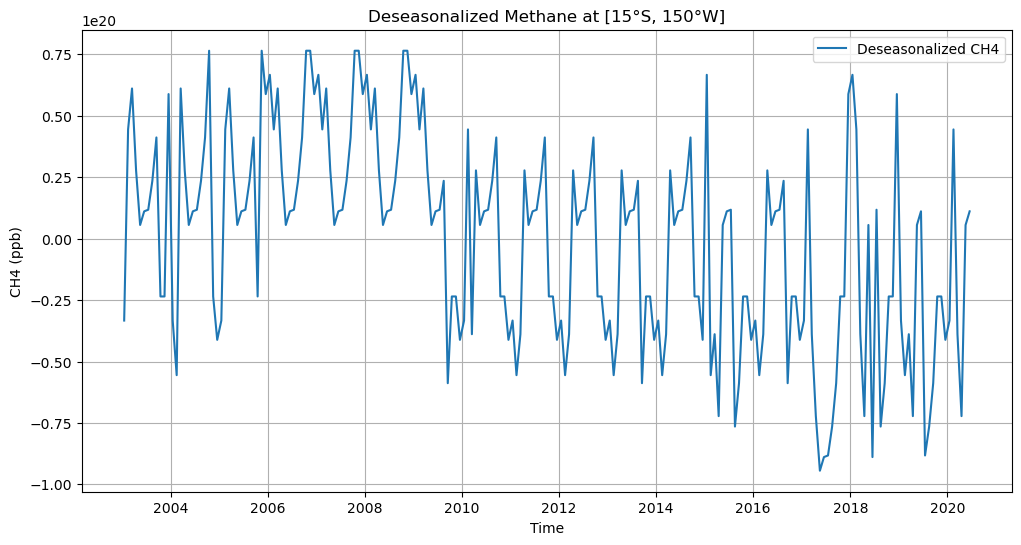

In [3]:
# 任务1.3： 特定点[15°S, 150°W]去季节化时间序列
target_lat = -15  # 15°S
target_lon = -150  # 150°W

lat_arr = ds.variables['lat'][:]
lon_arr = ds.variables['lon'][:]
lat_idx = np.abs(lat_arr - target_lat).argmin()
lon_idx = np.abs(lon_arr - target_lon).argmin()

point_ch4 = xch4[:, lat_idx, lon_idx]  # 提取该点时间序列

# 计算每月气候学（季节平均值）
monthly_clim = []
for m in range(1, 13):
    m_mask = (months == m)
    if np.any(m_mask):
        m_mean = np.nanmean(point_ch4[m_mask])
    else:
        m_mean = np.nan
    monthly_clim.append(m_mean)

# 去季节化：原始值 - 对应月份的气候学平均值
deseasonalized = point_ch4 - [monthly_clim[mon-1] for mon in months]

plt.figure(figsize=(12, 6))
plt.plot(df_time['date'], deseasonalized, label='Deseasonalized CH4')
plt.xlabel('Time')
plt.ylabel('CH4 (ppb)')
plt.title('Deseasonalized Methane at [15°S, 150°W]')
plt.grid(True)
plt.legend()
plt.savefig('deseasonalized_point.png')
plt.show()

ds.close()


In [5]:
#任务2
import xarray as xr
import matplotlib.pyplot as plt

file_path = r'C:\Users\Morchaim&Hwachi\NOAA_NCDC_ERSST_v3b_SST.nc'
ds = xr.open_dataset(file_path)
# 查看数据结构（确认经纬度范围）
print(ds)
print("经度范围：", ds.lon.min().values, ds.lon.max().values)
print("纬度范围：", ds.lat.min().values, ds.lat.max().values)

<xarray.Dataset> Size: 44MB
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 356B -88.0 -86.0 -84.0 -82.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 5kB 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 44MB ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...
经度范围： 0.0 358.0
纬度范围： -88.0 88.0


In [6]:
# 定义Niño 3.4区域 
lat_bounds = [-5, 5] 
# 经度：170°W到120°W，数据中经度是0~360，转换为190°E到240°E
lon_bounds = [190, 240]

# 选择区域内的SST数据
sst = ds['sst'].sel(
    lat=slice(lat_bounds[0], lat_bounds[1]),
    lon=slice(lon_bounds[0], lon_bounds[1])
)

In [7]:
# 计算月度气候态（Monthly Climatology）
sst_clim = sst.groupby('time.month').mean(dim='time')

In [8]:
#4. 计算SST异常（Anomalies）
sst_anomaly = sst.groupby('time.month') - sst_clim

# 计算Niño 3.4指数（区域平均异常）
nino34 = sst_anomaly.mean(dim=['lat', 'lon'])


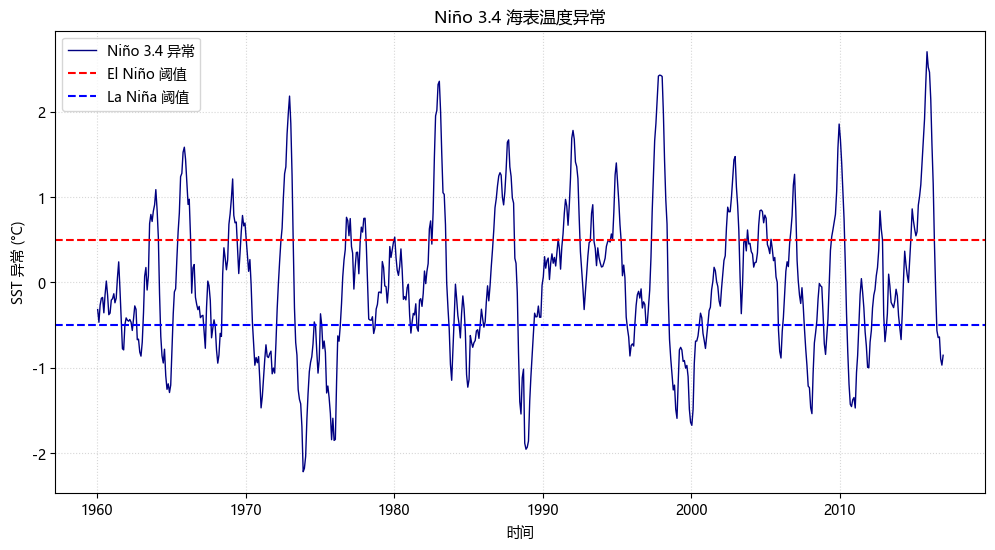

In [9]:
#可视化Niño 3.4指数
plt.figure(figsize=(12, 6))

nino34.plot(linewidth=1, color='navy', label='Niño 3.4 异常')  
plt.axhline(y=0.5, color='red', linestyle='--', label='El Niño 阈值')
plt.axhline(y=-0.5, color='blue', linestyle='--', label='La Niña 阈值')

# 字体更换为微软雅黑字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
plt.rcParams['axes.unicode_minus'] = False    

plt.title('Niño 3.4 海表温度异常')
plt.ylabel('SST 异常 (°C)')
plt.xlabel('时间')
plt.legend()
plt.grid(linestyle=':', alpha=0.5)
plt.show()

In [11]:
#任务3
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import warnings  # 导入警告处理模块
from matplotlib import font_manager  # 正确导入
#读取数据集并查看变量 
file_path = r'C:\Users\Morchaim&Hwachi\data_stream-moda.nc' 
ds = xr.open_dataset(file_path)

# 打印数据集基本信息和所有变量，确认可用变量名
print("数据集结构：")
print(ds)
print("\n所有可用变量：", list(ds.variables))

数据集结构：
<xarray.Dataset> Size: 19GB
Dimensions:     (valid_time: 66, latitude: 1801, longitude: 3600)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 528B 2015-01-01 ... 2025-06-01
  * latitude    (latitude) float64 14kB 90.0 89.9 89.8 ... -89.8 -89.9 -90.0
  * longitude   (longitude) float64 29kB -180.0 -179.9 -179.8 ... 179.8 179.9
    expver      (valid_time) <U4 1kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 2GB ...
    skt         (valid_time, latitude, longitude) float32 2GB ...
    stl1        (valid_time, latitude, longitude) float32 2GB ...
    lblt        (valid_time, latitude, longitude) float32 2GB ...
    asn         (valid_time, latitude, longitude) float32 2GB ...
    swvl1       (valid_time, latitude, longitude) float32 2GB ...
    ssr         (valid_time, latitude, longitude) float32 2GB ...
    evabs       (valid_time, latitude, longitude) float32 2GB ...
    u10         (valid_time, latitude, lon

In [12]:
# 抑制字体查找警告
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")  
# 字体设置 
plt.rcParams["font.family"] = ["Microsoft YaHei", "SimHei"]  
plt.rcParams["axes.unicode_minus"] = False  # 确保负号正常显示

In [24]:
#读取数据集并选择变量（取t2m）
file_path = r'C:\Users\Morchaim&Hwachi\data_stream-moda.nc'
ds = xr.open_dataset(file_path)
var_name = 't2m' 
data = ds[var_name]
time_dim = 'valid_time'  # 明确数据集的时间维度名

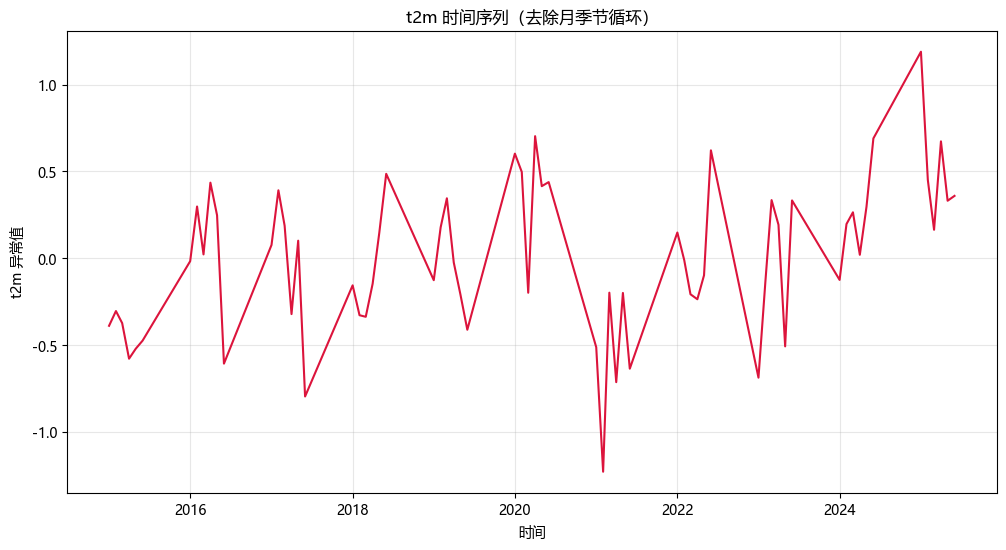

In [14]:
# 任务3.1：绘制“去除月季节循环”的时间序列
# 计算月气候态（多年同月平均值）
climatology = data.groupby('valid_time.month').mean(dim='valid_time')
# 去除季节循环（原数据 - 对应月气候态）
anomaly = data.groupby('valid_time.month') - climatology
# 空间平均（全局平均）
anomaly_mean = anomaly.mean(dim=['latitude', 'longitude'])

plt.figure(figsize=(12, 6))
anomaly_mean.plot(linewidth=1.5, color='crimson')
plt.title(f'{var_name} 时间序列（去除月季节循环）')
plt.xlabel('时间')
plt.ylabel(f'{var_name} 异常值')
plt.grid(alpha=0.3)
plt.show()

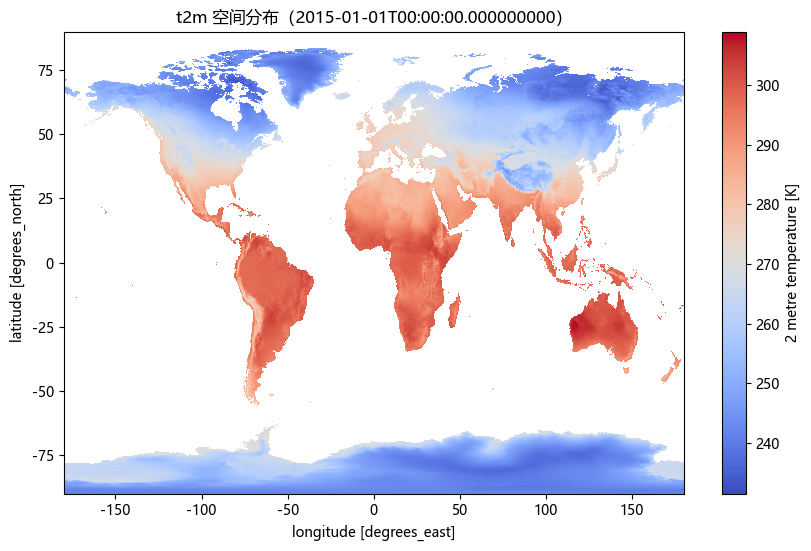

In [15]:
#任务3.2：绘制5种不同的图 
# 图1：某一时刻的空间分布图（第一个时间步）
data_first = data.isel(valid_time=0)
plt.figure(figsize=(10, 6))
data_first.plot(cmap='coolwarm')  # 温度类变量用冷暖色
plt.title(f'{var_name} 空间分布（{data_first.valid_time.values}）')
plt.show()

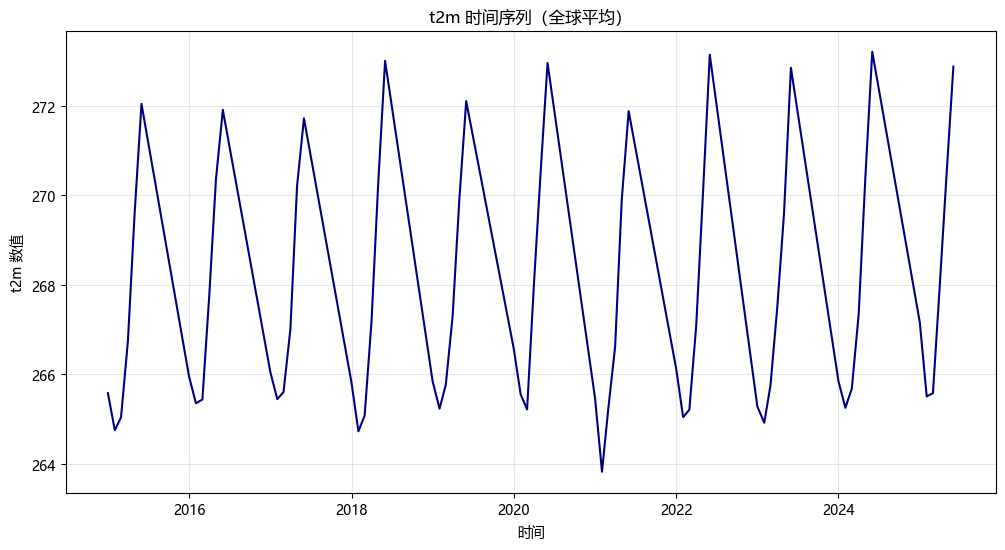

In [16]:
# 图2：变量的时间序列（空间平均）
data_time_mean = data.mean(dim=['latitude', 'longitude'])
plt.figure(figsize=(12, 6))
data_time_mean.plot(linewidth=1.5, color='navy')
plt.title(f'{var_name} 时间序列（全球平均）')
plt.xlabel('时间')
plt.ylabel(f'{var_name} 数值')
plt.grid(alpha=0.3)
plt.show()

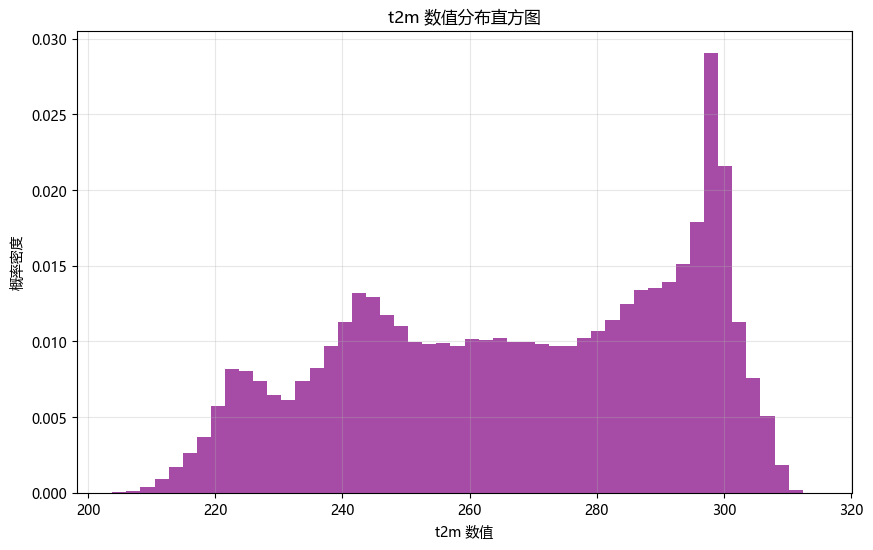

In [18]:
# 图3：变量的数值分布直方图
data_flat = data.values.flatten()  # 展平数据为一维数组
plt.figure(figsize=(10, 6))
plt.hist(data_flat, bins=50, density=True, alpha=0.7, color='purple')
plt.title(f'{var_name} 数值分布直方图')
plt.xlabel(f'{var_name} 数值')
plt.ylabel('概率密度')
plt.grid(alpha=0.3)
plt.show()

数据集实际季节标签： ['DJF' 'JJA' 'MAM']


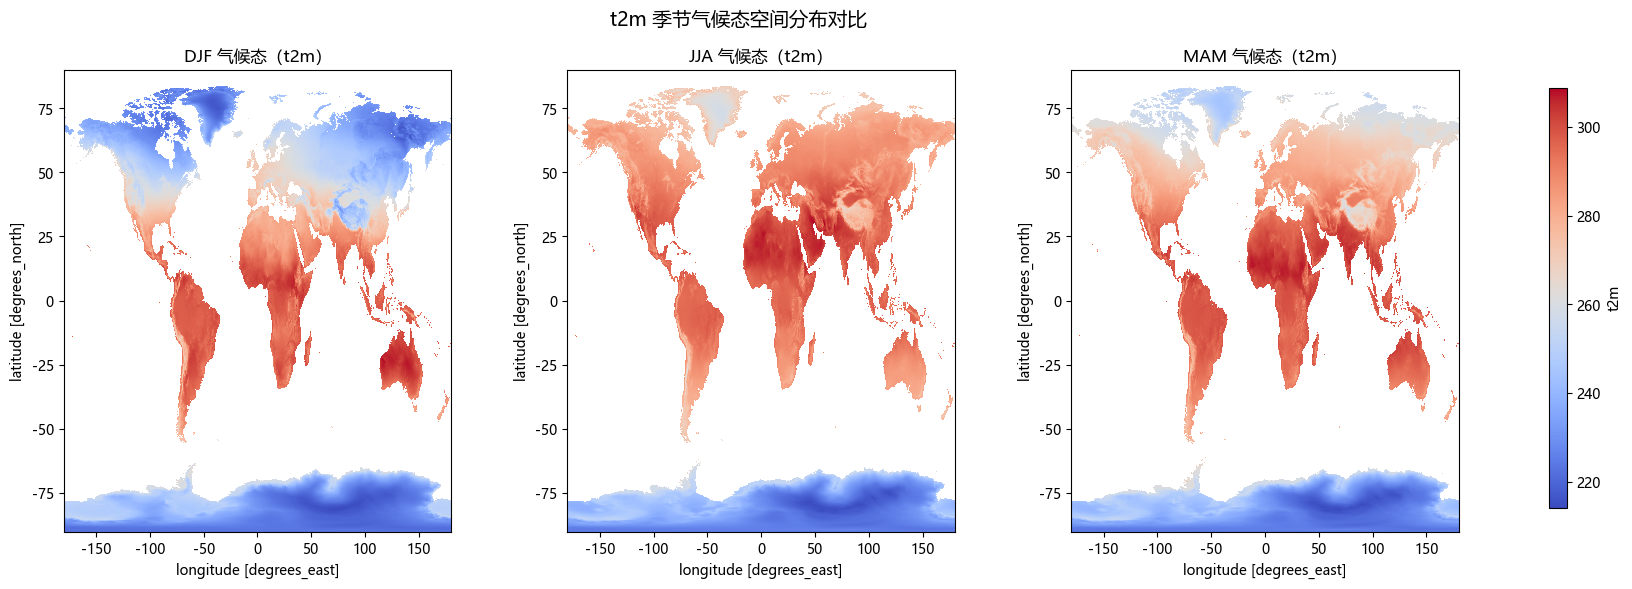

In [27]:
# 图4：多季节气候态空间分布对比
climatology_season = ds[var_name].groupby(f'{time_dim}.season').mean(dim=time_dim)
print("数据集实际季节标签：", climatology_season.season.values)  
seasons = list(climatology_season.season.values)  

# 调整子图布局为1×3（因数据集种季节数量为3）
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
axes = axes.flatten()

for i, season in enumerate(seasons):
    clim = climatology_season.sel(season=season)
    im = clim.plot(ax=axes[i], cmap='coolwarm', add_colorbar=False)
    axes[i].set_title(f'{season} 气候态（{var_name}）')

# 统一颜色条
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])  # 对比一开始画的缩小了颜色条宽度和调整水平位置
fig.colorbar(im, cax=cbar_ax, label=var_name)
plt.subplots_adjust(right=0.9, wspace=0.3)  # 预留右侧空间给颜色条，同时调整子图间距
plt.suptitle(f'{var_name} 季节气候态空间分布对比', fontsize=14)  # 适当减小标题字号
plt.show()

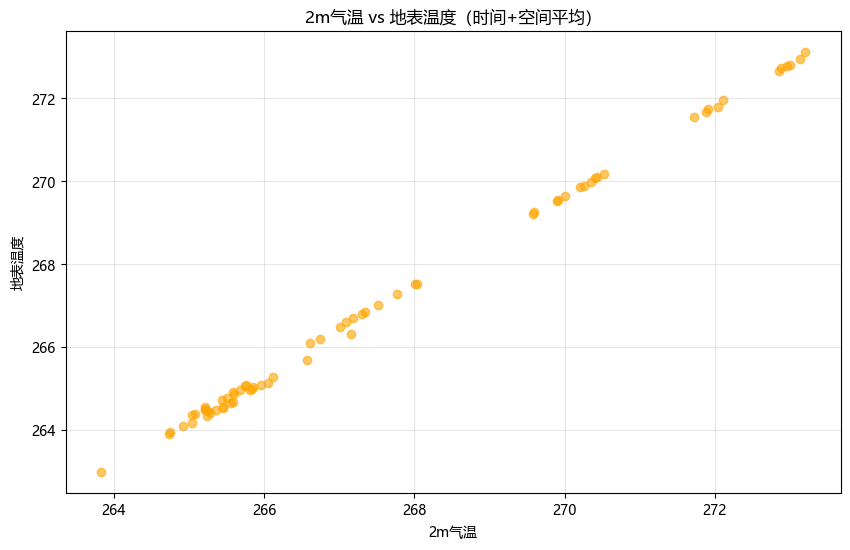

In [20]:
# 图5：t2m与skt的散点图
if 'skt' in ds.variables:
    skt = ds['skt']
    t2m_mean = data.mean(dim=['latitude', 'longitude'])
    skt_mean = skt.mean(dim=['latitude', 'longitude'])
    plt.figure(figsize=(10, 6))
    plt.scatter(t2m_mean, skt_mean, color='orange', alpha=0.6)
    plt.title('2m气温 vs 地表温度（时间+空间平均）')
    plt.xlabel('2m气温')
    plt.ylabel('地表温度')
    plt.grid(alpha=0.3)
    plt.show()